In [1]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import \
    ImageDataGenerator,load_img,array_to_img,img_to_array
from tensorflow.keras.applications import resnet50,ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# DATA

In [3]:
train_datagen = ImageDataGenerator(\
    preprocessing_function=resnet50.preprocess_input)

In [4]:
train_generator = train_datagen.\
    flow_from_directory('rural_and_urban_photos/train/', 
        target_size = (224, 224),
        color_mode = 'rgb',
        batch_size = 32,
        class_mode = 'categorical',
        shuffle = True)

Found 72 images belonging to 2 classes.


In [5]:
print([x for x in dir(train_generator) if not x.startswith('_')])

['allowed_class_modes', 'batch_index', 'batch_size', 'class_indices', 'class_mode', 'classes', 'color_mode', 'data_format', 'directory', 'dtype', 'filenames', 'filepaths', 'image_data_generator', 'image_shape', 'index_array', 'index_generator', 'interpolation', 'labels', 'lock', 'n', 'next', 'num_classes', 'on_epoch_end', 'reset', 'sample_weight', 'samples', 'save_format', 'save_prefix', 'save_to_dir', 'seed', 'set_processing_attrs', 'shuffle', 'split', 'subset', 'target_size', 'total_batches_seen', 'white_list_formats']


In [6]:
test_datagen = ImageDataGenerator()
raw_xtest,ytest = test_datagen.\
    flow_from_directory('rural_and_urban_photos/val/',
                target_size = (224, 224)).next()
xtest = resnet50.preprocess_input(raw_xtest)

Found 20 images belonging to 2 classes.


# MODEL

In [7]:
base_model = ResNet50(weights='imagenet', include_top = False)

In [8]:
#for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu',name='my_layer_1')(x)
x = Dense(512, activation='relu',name='my_layer_2')(x)
preds = Dense(2,name='my_layer_3', activation ='softmax')(x)

In [10]:
transfer_model = \
    tf.keras.models.Model(inputs=base_model.input, outputs=preds)

In [12]:
for layer in transfer_model.layers[:175]:
    layer.trainable = False
for layer in transfer_model.layers[175:]:
    layer.trainable = True

In [13]:
transfer_model.compile(optimizer='Adam', 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

# TRAINING

In [14]:
%%time
history = transfer_model.fit_generator(generator = train_generator, 
    steps_per_epoch=train_generator.n//train_generator.batch_size, 
    validation_data=(xtest,ytest),
    epochs = 5)

Train for 2 steps, validate on 20 samples
Epoch 1/5
2/2 [==============================] - 4s 2s/step - loss: 2.4485 - accuracy: 0.5000 - val_loss: 0.7662 - val_accuracy: 0.7000
Epoch 2/5
2/2 [==============================] - 0s 141ms/step - loss: 0.5358 - accuracy: 0.7000 - val_loss: 0.5088 - val_accuracy: 0.8500
Epoch 3/5
2/2 [==============================] - 0s 204ms/step - loss: 0.1291 - accuracy: 0.9688 - val_loss: 0.0870 - val_accuracy: 0.9500
Epoch 4/5
2/2 [==============================] - 0s 210ms/step - loss: 0.2076 - accuracy: 0.8906 - val_loss: 0.0745 - val_accuracy: 0.9500
Epoch 5/5
2/2 [==============================] - 0s 162ms/step - loss: 8.1511e-04 - accuracy: 1.0000 - val_loss: 0.2673 - val_accuracy: 0.9500
CPU times: user 6.17 s, sys: 500 ms, total: 6.67 s
Wall time: 6.06 s


In [15]:
transfer_model.evaluate(xtest,ytest)

20/20 [==============================] - 0s 2ms/sample - loss: 0.2673 - accuracy: 0.9500


[0.2672736644744873, 0.95]

# VISUALIZZAZIONE

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


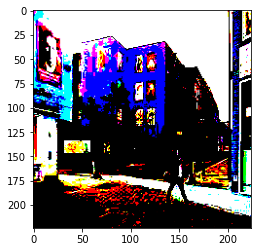

In [16]:
plt.imshow(xtest[13]);

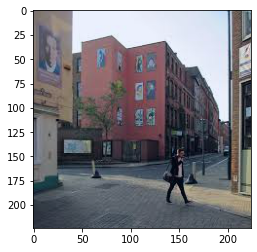

In [17]:
plt.imshow(array_to_img(raw_xtest[13]));

In [18]:
predictions = transfer_model(xtest)

In [19]:
string_predictions = np.array(['rural','urban'])\
    [np.argmax(predictions.numpy(),axis=1)]

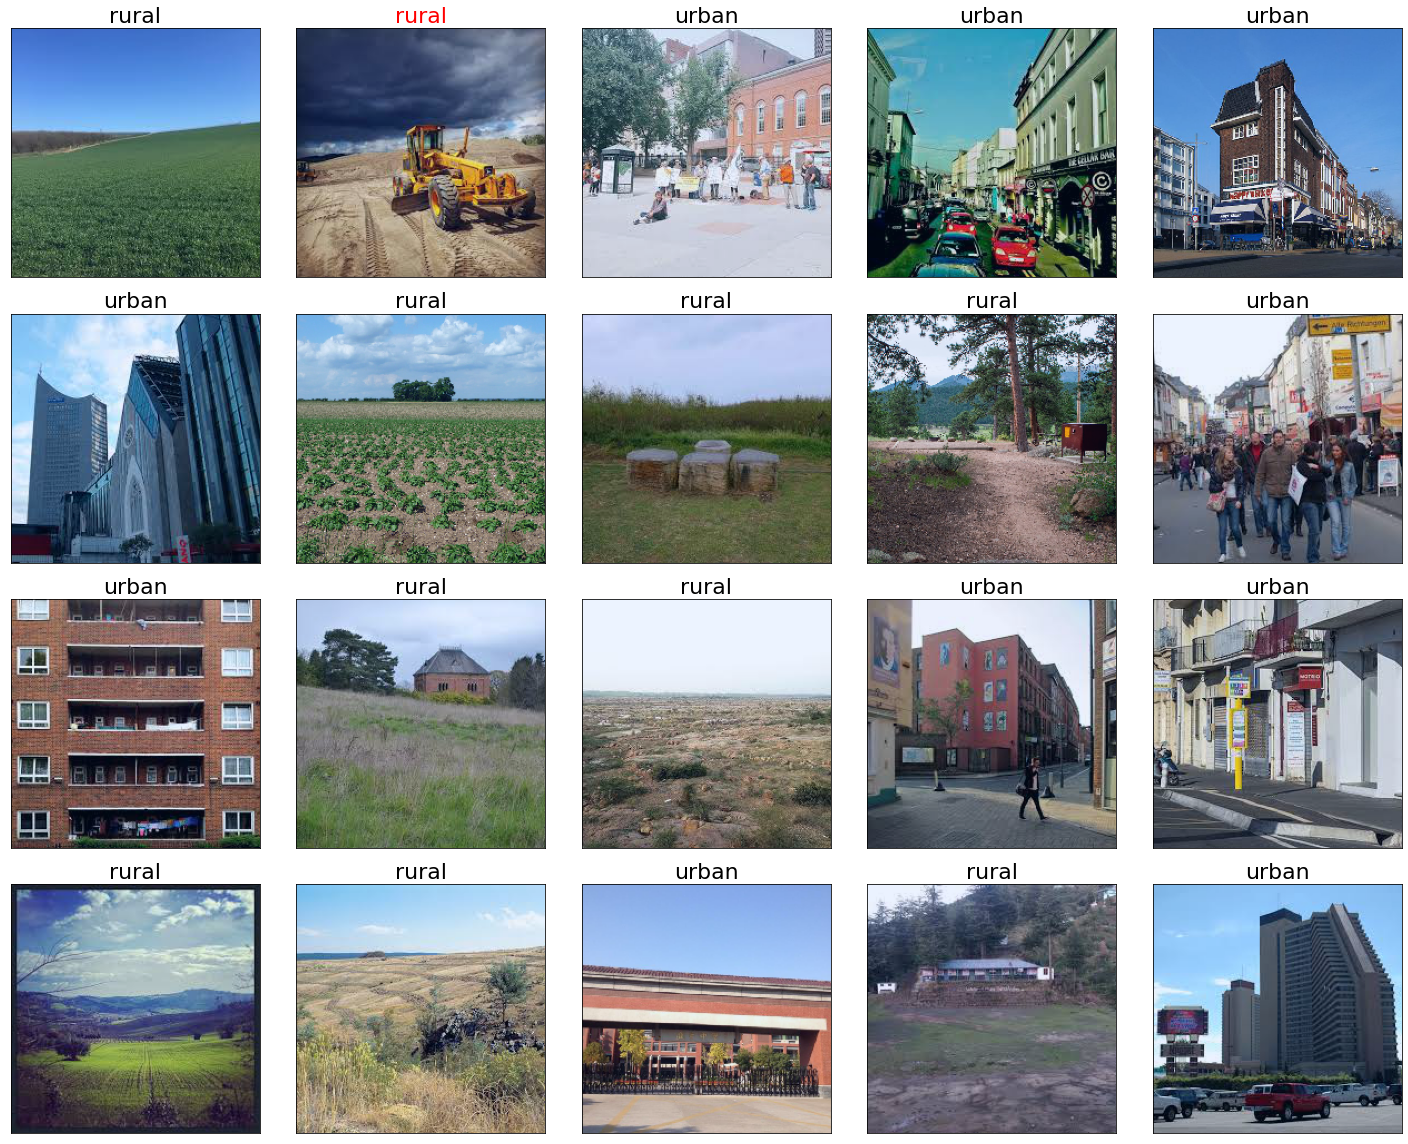

In [20]:
plt.figure(figsize=(20,16))
for k in range(20):
    plt.subplot(4,5,k+1)
    plt.imshow(array_to_img(raw_xtest[k]))
    gt_label = ['rural','urban'][np.argmax(ytest[k])]
    plt.title(gt_label,fontsize=22,color='black' \
              if gt_label==string_predictions[k] else 'red')
    plt.xticks([],[])
    plt.yticks([],[])
plt.tight_layout();

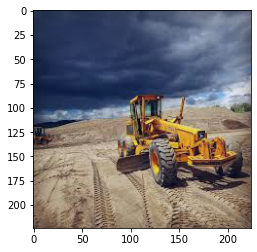

In [24]:
plt.imshow(array_to_img(raw_xtest[1]))

In [25]:
ytest[1]

array([1., 0.], dtype=float32)

In [26]:
predictions[1].numpy()

array([0.00526303, 0.99473697], dtype=float32)